In [ ]:
import os
os.makedirs('/root/.kaggle', exist_ok=True)
os.environ['KAGGLE_CONFIG_DIR'] = '/root/.kaggle'

import shutil
shutil.move('/content/kaggle(5)(1)(4).json', '/root/.kaggle/kaggle.json')

from kaggle.api.kaggle_api_extended import KaggleApi

# Authenticate using the Kaggle API
api = KaggleApi()
api.authenticate()

# Download the dataset
api.dataset_download_files('ninadaithal/imagesoasis', path='.', unzip=True)


print("Dataset downloaded and extracted!")


Dataset URL: https://www.kaggle.com/datasets/ninadaithal/imagesoasis
Dataset downloaded and extracted!


# Necessary imports for EDA

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
from collections import Counter
from tqdm import tqdm


# Classes

In [ ]:
dataset_path = '/content/Data'
class_names = os.listdir(dataset_path)

print("Classes found:", class_names)


Classes found: ['Mild Dementia', 'Non Demented', 'Very mild Dementia', 'Moderate Dementia']


# Number of images per each class

In [ ]:
dataset_path = 'Data'
class_names = os.listdir(dataset_path)

total_images = 0
image_shapes = []


for cls in class_names:
    cls_path = os.path.join(dataset_path, cls)
    images = os.listdir(cls_path)
    num_images = len(images)
    total_images += num_images

    for img_name in images:
        img_path = os.path.join(cls_path, img_name)
        try:
            img = Image.open(img_path).convert('RGB')  # Ensures 3 channels
            image_shapes.append(np.array(img).shape)
        except:
            continue

    print(f"{cls}: {num_images} images")

# Convert to array for easy stats
image_shapes = np.array(image_shapes)

print(f"Total Images: {total_images}")

Mild Dementia: 5002 images
Non Demented: 67222 images
Very mild Dementia: 13725 images
Moderate Dementia: 488 images
Total Images: 86437


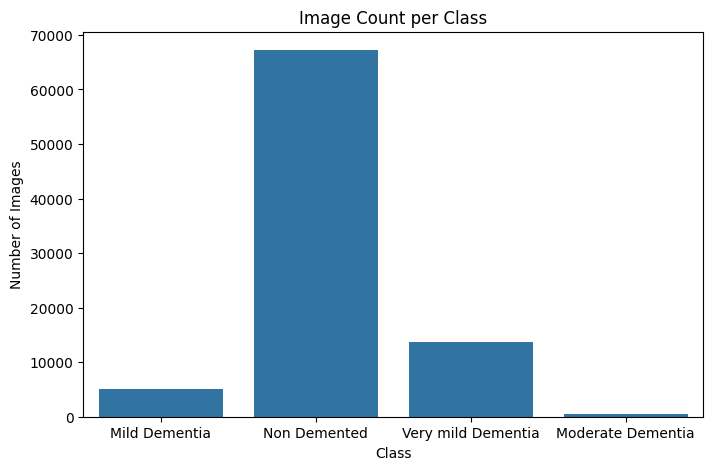

In [ ]:
class_counts = {cls: len(os.listdir(os.path.join(dataset_path, cls))) for cls in class_names}

# Bar Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title("Image Count per Class")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()

# Images height and width statistics

In [ ]:
heights = image_shapes[:, 0]
widths = image_shapes[:, 1]
channels = image_shapes[:, 2]

print(f"Image Height - Mean: {np.mean(heights):.1f}, Min: {np.min(heights)}, Max: {np.max(heights)}")
print(f"Image Width  - Mean: {np.mean(widths):.1f}, Min: {np.min(widths)}, Max: {np.max(widths)}")
print(f"Channels: {np.unique(channels)}")

Image Height - Mean: 248.0, Min: 248, Max: 248
Image Width  - Mean: 496.0, Min: 496, Max: 496
Channels: [3]


# Display a sample image for each class

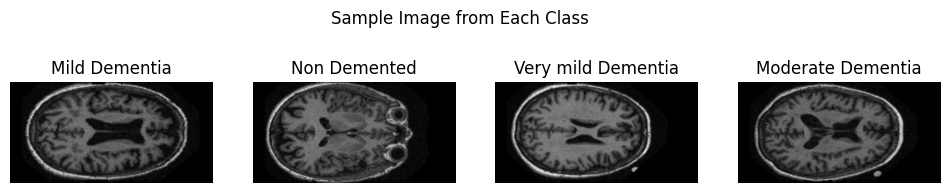

In [ ]:
plt.figure(figsize=(12, 6))
for i, cls in enumerate(class_names):
    img_path = os.path.join(dataset_path, cls, os.listdir(os.path.join(dataset_path, cls))[0])
    img = Image.open(img_path)
    plt.subplot(1, len(class_names), i+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis('off')
plt.suptitle("Sample Image from Each Class",  y=0.7)
plt.show()


# Pixels values distribution

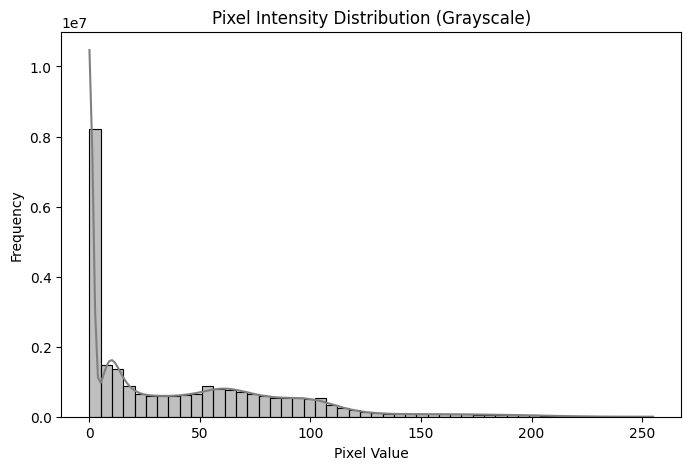

In [ ]:
pixel_values = []

for cls in class_names:
    class_path = os.path.join(dataset_path, cls)
    for file in os.listdir(class_path)[:50]:  # sample of 50 images per class
        try:
            img = Image.open(os.path.join(class_path, file)).convert('L')  # Converting to grayscale
            pixel_values.extend(np.array(img).flatten())
        except:
            continue

plt.figure(figsize=(8, 5))
sns.histplot(pixel_values, bins=50, kde=True, color='gray')
plt.title("Pixel Intensity Distribution (Grayscale)")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()


# Checking for duplicate and corrupted images

In [ ]:
from hashlib import md5

hashes = set()
duplicates = []
corrupted = []

for cls in class_names:
    class_path = os.path.join(dataset_path, cls)
    for file in os.listdir(class_path):
        img_path = os.path.join(class_path, file)
        try:
            with open(img_path, 'rb') as f:
                file_hash = md5(f.read()).hexdigest()
            if file_hash in hashes:
                duplicates.append(img_path)
            else:
                hashes.add(file_hash)
        except:
            corrupted.append(img_path)

print(f"Found {len(duplicates)} duplicate images")
print(f"Found {len(corrupted)} corrupted images")


Found 0 duplicate images
Found 0 corrupted images


# Necessary imports for data preprocessig and implementing deep learning models

In [ ]:
import zipfile
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import cv2
from glob import glob

# Dividing the data into two new folders: train and test

In [ ]:
import shutil

# Define paths for each class
path_1 = '/content/Data/Mild Dementia'
path_2 = '/content/Data/Moderate Dementia'
path_3 = '/content/Data/Non Demented'
path_4 = '/content/Data/Very mild Dementia'

# Root directory for train and test split
rootdir = '/content/Data'
train_dir = os.path.join(rootdir, 'train')
test_dir = os.path.join(rootdir, 'test')

# Create train and test folders for each class
classes = {'1': 'Mild Dementia', '2': 'Moderate Dementia', '3': 'Non Demented', '4': 'Very mild Dementia'}
for class_name in classes.values():
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

# Split and copy files
def split_and_copy(source_path, class_name, train_dest, test_dest, test_ratio=0.2):
    all_files = os.listdir(source_path)
    np.random.shuffle(all_files)  # Shuffle the files

    # Split the data into train and test
    train_files, test_files = np.split(np.array(all_files),
                                       [int(len(all_files) * (1 - test_ratio))])

    # Copy train files
    for file in train_files:
        src = os.path.join(source_path, file)
        dest = os.path.join(train_dest, class_name, file)
        shutil.copy(src, dest)

    # Copy test files
    for file in test_files:
        src = os.path.join(source_path, file)
        dest = os.path.join(test_dest, class_name, file)
        shutil.copy(src, dest)

# Apply the function to all classes
split_and_copy(path_1, 'Mild Dementia', train_dir, test_dir)
split_and_copy(path_2, 'Moderate Dementia', train_dir, test_dir)
split_and_copy(path_3, 'Non Demented', train_dir, test_dir)
split_and_copy(path_4, 'Very mild Dementia', train_dir, test_dir)

print("Train-test split completed successfully!")


Train-test split completed successfully!


In [ ]:
train_path = '/content/Data/train'
test_path = '/content/Data/test'

# Data preprocessing(Pixels normalization, images resizing, data augmentation)

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip= True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip= True,
    fill_mode='nearest'
)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=4,
    class_mode='categorical',
    shuffle=True
)

Found 69148 images belonging to 4 classes.
Found 17289 images belonging to 4 classes.


# Visualizig images after data preprocessing (data augmentation)

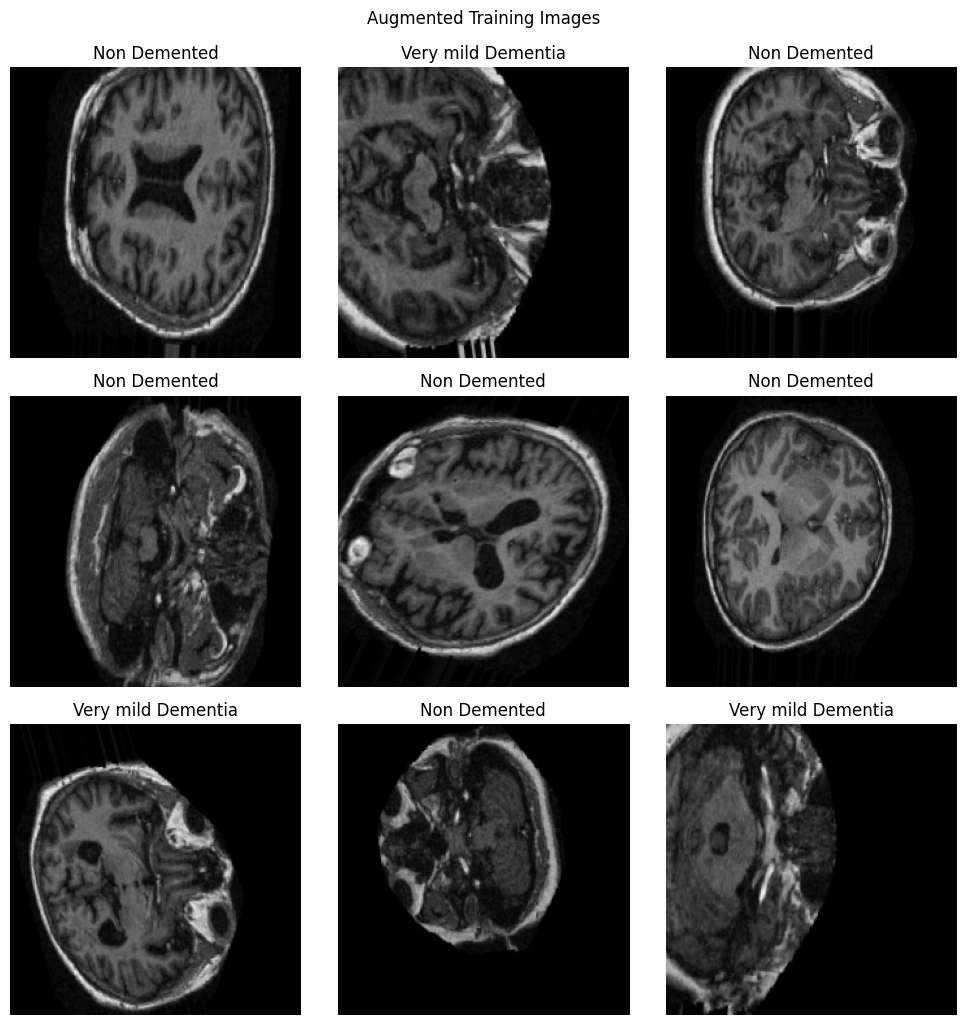

In [ ]:
images, labels = next(train_generator)

class_indices = train_generator.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    class_name = idx_to_class[np.argmax(labels[i])]
    plt.title(class_name)
    plt.axis('off')
plt.tight_layout()
plt.suptitle("Augmented Training Images", y=1.02)
plt.show()


# Train and test images statistics

In [ ]:
print("Class indices:", train_generator.class_indices)

print("\nTrain set class distribution:")
for class_name, count in zip(train_generator.class_indices.keys(), train_generator.classes):
    print(f"{class_name}: {(train_generator.classes == train_generator.class_indices[class_name]).sum()}")

print("\nTest set class distribution:")
for class_name in test_generator.class_indices.keys():
    print(f"{class_name}: {(test_generator.classes == test_generator.class_indices[class_name]).sum()}")


Class indices: {'Mild Dementia': 0, 'Moderate Dementia': 1, 'Non Demented': 2, 'Very mild Dementia': 3}

Train set class distribution:
Mild Dementia: 4001
Moderate Dementia: 390
Non Demented: 53777
Very mild Dementia: 10980

Test set class distribution:
Mild Dementia: 1001
Moderate Dementia: 98
Non Demented: 13445
Very mild Dementia: 2745


<ipython-input-21-5f7473790666>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='class', data=train_df, palette="pastel")


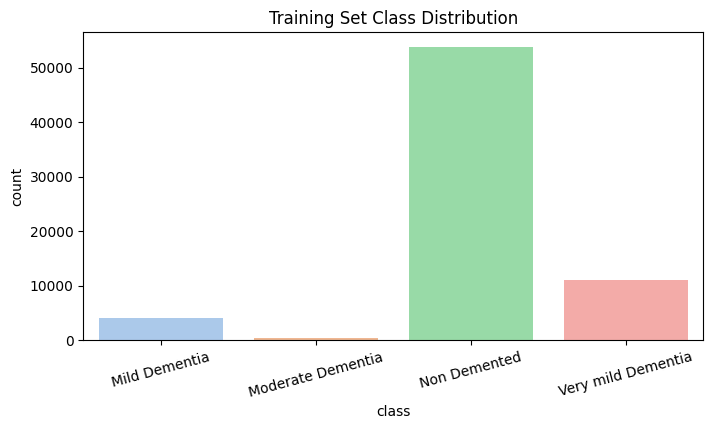

In [ ]:
import pandas as pd

# For training set
train_labels = [idx_to_class[c] for c in train_generator.classes]
train_df = pd.DataFrame(train_labels, columns=['class'])

plt.figure(figsize=(8, 4))
sns.countplot(x='class', data=train_df, palette="pastel")
plt.title("Training Set Class Distribution")
plt.xticks(rotation=15)
plt.show()

<ipython-input-22-3fead996d162>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='class', data=train_df, palette="pastel")


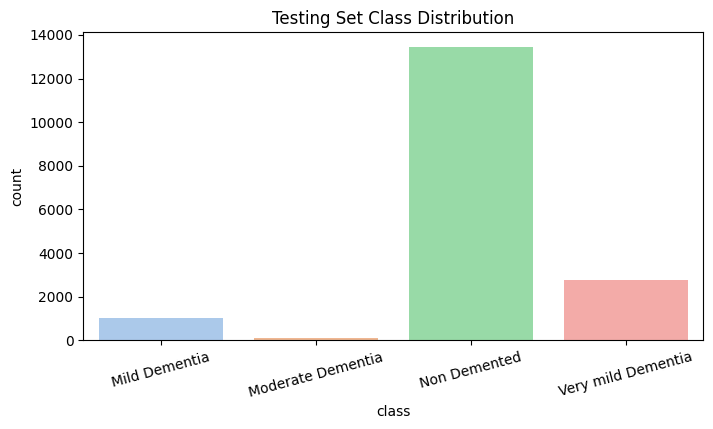

In [ ]:
# For testing set
test_labels = [idx_to_class[c] for c in test_generator.classes]
train_df = pd.DataFrame(test_labels, columns=['class'])

plt.figure(figsize=(8, 4))
sns.countplot(x='class', data=train_df, palette="pastel")
plt.title("Testing Set Class Distribution")
plt.xticks(rotation=15)
plt.show()

#Feature Extraction & Model implementation:

Using VGG16 as a feature extractor and classifying using 100 neurons and a softmax activation function as well as using RELU, ADAM optimizer, a regularization rate of 0.0006, and 10 epochs.

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2


# Load VGG16 without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers to use as feature extractor (No fine-tuning)
for layer in base_model.layers:
    layer.trainable = False

# Add top layer of 100 neurons, relu, regularization rate of 0.0006, and softmax
x = base_model.output
x = Flatten()(x)
x = Dense(100, activation='relu', kernel_regularizer=l2(0.0006))(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)

# Combine base and top layers
model = Model(inputs=base_model.input, outputs=output)

# Compile model
optimizer = Adam()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Summary
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │     2,508,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           404 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,223,992 (65.70 MB)

 Trainable params: 2,509,304 (9.57 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    callbacks=[early_stop]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 1347s 617ms/step - accuracy: 0.7662 - loss: 0.7043 - val_accuracy: 0.7809 - val_loss: 0.5674
Epoch 2/10
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 1321s 611ms/step - accuracy: 0.7842 - loss: 0.5699 - val_accuracy: 0.7858 - val_loss: 0.5868
Epoch 3/10
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 1358s 628ms/step - accuracy: 0.7867 - loss: 0.5658 - val_accuracy: 0.7833 - val_loss: 0.5633
Epoch 4/10
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 1317s 610ms/step - accuracy: 0.7805 - loss: 0.5582 - val_accuracy: 0.7780 - val_loss: 0.5733
Epoch 5/10
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 1325s 613ms/step - accuracy: 0.7746 - loss: 0.5686 - val_accuracy: 0.7777 - val_loss: 0.5454
Epoch 6/10
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 1339s 620ms/step - accuracy: 0.7798 - loss: 0.5552 - val_accuracy: 0.7782 - val_loss: 0.5896
Epoch 7/10
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 1310s 606ms/step - accuracy: 0.7816 - loss: 0.5579 - val_accuracy: 0.7880 - val_loss: 0.5512
Epoch 8/10
1931/2161 ━━━━━━━━━━━━━━━━━━━━ 1:49 475ms/st